# Model Training

### Imports

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import sagemaker
import os
import warnings

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from io import StringIO

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


## Load the Train Dataset

In [3]:
train_df = pd.read_csv('s3://team6datasets/splitDatasets/train.csv')

In [4]:
train_df.head()

,CustomerID,gender_Agender,gender_Bigender,gender_Female,gender_Genderfluid,gender_Genderqueer,gender_Male,gender_Non-binary,gender_Polygender,Education_2n Cycle,...,SpendingCategory_Medium,SpendingCategory_High,SpendingCategory_Very High,IncomeLevel_Low,IncomeLevel_Medium,IncomeLevel_High,IncomeLevel_Very High,Purchase_Frequency,Age,Total_Spent_byCustomer
0,4426,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.652632,0.892857,0.021736
1,1100,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.589474,0.839286,0.027672
2,3602,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.547368,0.678571,0.021624
3,5268,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.421053,0.714286,0.028717
4,716,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.421053,0.357143,0.024864


In [5]:
train_df.columns

Index(['CustomerID', 'gender_Agender', 'gender_Bigender', 'gender_Female',
       'gender_Genderfluid', 'gender_Genderqueer', 'gender_Male',
       'gender_Non-binary', 'gender_Polygender', 'Education_2n Cycle',
       'Education_Basic', 'Education_Graduation', 'Education_Master',
       'Education_PhD', 'Marital_Status_Absurd', 'Marital_Status_Alone',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Together',
       'Marital_Status_Widow', 'Marital_Status_YOLO', 'Kidhome_0', 'Kidhome_1',
       'Kidhome_2', 'Teenhome_0', 'Teenhome_1', 'Teenhome_2', 'region_Africa',
       'region_Asia', 'region_Central America', 'region_Europe',
       'region_North America', 'region_Oceania', 'region_South America',
       'SpendingCategory_Low', 'SpendingCategory_Medium',
       'SpendingCategory_High', 'SpendingCategory_Very High',
       'IncomeLevel_Low', 'IncomeLevel_Medium', 'IncomeLevel_High',
       'IncomeLevel_Very High', 'Purchase

## Dimensionality Reduction using Variance for Training Dataset

In [6]:
# Set the variance threshold
variance_threshold = 0.2

# Create a VarianceThreshold object
selector = VarianceThreshold(threshold=variance_threshold)

# Fit the selector to the data 
selector.fit(train_df)

# Get the support mask 
support = selector.get_support(indices=True)

# Select features based on the support mask
reduced_features = train_df.iloc[:, support]  

# Now 'reduced_features' is a DataFrame containing features with variance exceeding the threshold
print(f"Number of features removed: {len(train_df.columns) - len(reduced_features.columns)}")

Number of features removed: 35


In [7]:
reduced_features.shape

(284778, 11)

## Model Training with KMeans Algorithm

### Use Elbow Method to Determine Ideal K

In [8]:
# Check if the image file already exists
if os.path.isfile('elbow_method.png'):
    print("Elbow method already run. Image found in folder.")
else:
    # Define a range of k values
    k_values = range(2, 11)  

    # Convert the reduced_features DataFrame to float32
    reduced_features_float32 = reduced_features.astype('float32')

    # Train KMeans models for each k value and compute WCSS
    wcss_values = []
    for k in k_values:
        kmeans = KMeans(role=role,
                        instance_count=1,
                        instance_type='ml.c4.xlarge',
                        k=k)
        kmeans.fit(kmeans.record_set(reduced_features_float32.values)) 
        # Filter the DataFrame for the row where metric_name is 'train:msd'
        wcss_row = kmeans.training_job_analytics.dataframe().loc[kmeans.training_job_analytics.dataframe()['metric_name'] == 'train:msd']
        # Extract the WCSS value from the 'value' column of the filtered row
        wcss_value = wcss_row['value'].iloc[0]
        # Append the WCSS value to the list
        wcss_values.append(wcss_value)

    # Plot the WCSS values against k
    plt.plot(k_values, wcss_values, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Within-cluster sum of squares (WCSS)')
    plt.savefig('elbow_method.png')  # Save the plot as an image
    plt.show()
    print("Elbow method run successfully. Image saved in folder.")

Elbow method already run. Image found in folder.


In [9]:
# Convert DataFrame to NumPy array (excluding CustomerID)
features_np = reduced_features.values.astype('float32')

# Define hyperparameters for KMeans model
hyperparameters = {'k': 4}

# Set k value
k_value = hyperparameters['k']

# Create KMeans model
kmeans = KMeans(n_clusters=k_value, init='random', n_init=10, random_state=42)

# Fit the model
print(f"Training model for k={k_value}...")
kmeans.fit(features_np)

# Get cluster labels
cluster_labels = kmeans.labels_

# Print centroids
print("Centroids:")
print(kmeans.cluster_centers_)

print(f"Model for k={k_value} trained.")

Training model for k=4...


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fc0db7ca1f0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fc0db75a0d0>
Traceback 

Centroids:
[[1.4224873e+03 4.4307831e-01 4.5655546e-01 3.4350345e-01 3.1941679e-01
  3.3707586e-01 3.2546753e-01 3.2569346e-01 3.4884211e-01 4.7565570e-01
  2.9311660e-01]
 [4.2773857e+03 4.4160640e-01 4.6339613e-01 3.4077647e-01 3.3293542e-01
  3.2628781e-01 3.1924108e-01 3.2036155e-01 3.6039138e-01 4.6431905e-01
  2.9060110e-01]
 [9.9009258e+03 4.6858788e-01 4.4081482e-01 3.3441460e-01 3.5839602e-01
  3.0717617e-01 3.3070534e-01 3.3503574e-01 3.3424860e-01 3.9743128e-01
  3.2022479e-01]
 [7.0101396e+03 4.6282870e-01 4.3391368e-01 3.3538470e-01 3.2441619e-01
  3.4019071e-01 3.1638119e-01 3.1781140e-01 3.6580300e-01 4.3578246e-01
  3.1587976e-01]]
Model for k=4 trained.


## Model Validation

In [10]:
validate_df = pd.read_csv('s3://team6datasets/splitDatasets/validation.csv')

In [11]:
validate_df.head()

,CustomerID,gender_Agender,gender_Bigender,gender_Female,gender_Genderfluid,gender_Genderqueer,gender_Male,gender_Non-binary,gender_Polygender,Education_2n Cycle,...,SpendingCategory_Medium,SpendingCategory_High,SpendingCategory_Very High,IncomeLevel_Low,IncomeLevel_Medium,IncomeLevel_High,IncomeLevel_Very High,Purchase_Frequency,Age,Total_Spent_byCustomer
0,9706,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.694737,0.071429,0.022270
1,5555,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.231579,0.053571,0.019130
2,3766,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.452632,0.714286,0.022333
3,6515,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.431579,0.660714,0.018234
4,1158,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.210526,0.053571,0.014316


### Dimensionality Reduction using Variance for Validation Dataset

In [12]:
# Set the variance threshold
variance_threshold = 0.2

# Create a VarianceThreshold object
selector = VarianceThreshold(threshold=variance_threshold)

# Fit the selector to the data
selector.fit(validate_df)

# Get the support mask
support = selector.get_support(indices=True)

# Select features based on the support mask
reduced_features_validate = validate_df.iloc[:, support]  

# Now 'reduced_features' is a DataFrame containing features with variance exceeding the threshold
print(f"Number of features removed: {len(validate_df.columns) - len(reduced_features_validate.columns)}")

Number of features removed: 35


In [13]:
reduced_features_validate.shape

(61024, 11)

In [14]:
# Show the reduced_features_validate DataFrame
print("Reduced Features DataFrame:")
reduced_features_validate.head()

Reduced Features DataFrame:


,CustomerID,gender_Female,gender_Male,Kidhome_0,Kidhome_1,Kidhome_2,Teenhome_0,Teenhome_1,Teenhome_2,region_Asia,region_Europe
0,9706,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,5555,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3766,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,6515,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1158,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


### Prediction of Clusters for Validation Data

In [15]:
# Convert DataFrame to NumPy array 
features_np_validate = reduced_features_validate.values.astype('float32')

# Predict clusters for Validation data
cluster_predictions = kmeans.predict(features_np_validate)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fc0db777160>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


## Evaluation

### Silhouette Score Calculation

In [16]:
# Calculate silhouette score
silhouette_avg = silhouette_score(features_np_validate, cluster_predictions)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.5778258442878723


### Davies-Bouldin Index Calculation

In [17]:
# Calculate Davies-Bouldin index
db_index = davies_bouldin_score(features_np_validate, cluster_predictions)
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 0.49616248869822865


### Visualization of Clusters using PCA

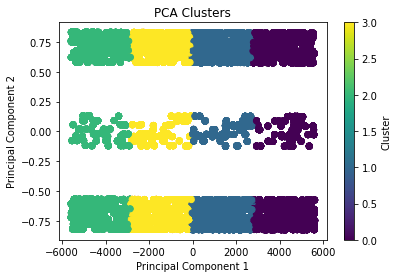

In [18]:
# Reduce dimensionality with PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_np_validate)

# Plot clusters
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=cluster_predictions, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Clusters')
plt.colorbar(label='Cluster')
plt.show()

### Analysis of Cluster Centroids

In [19]:
# Get cluster centroids
centroids = kmeans.cluster_centers_

# Create a DataFrame to show centroids
centroid_df = pd.DataFrame(centroids, columns=reduced_features_validate.columns)
print("Cluster Centroids:")
print(centroid_df)

Cluster Centroids:
    CustomerID  gender_Female  gender_Male  Kidhome_0  Kidhome_1  Kidhome_2  \
0  1422.487305       0.443078     0.456555   0.343503   0.319417   0.337076   
1  4277.385742       0.441606     0.463396   0.340776   0.332935   0.326288   
2  9900.925781       0.468588     0.440815   0.334415   0.358396   0.307176   
3  7010.139648       0.462829     0.433914   0.335385   0.324416   0.340191   

   Teenhome_0  Teenhome_1  Teenhome_2  region_Asia  region_Europe  
0    0.325468    0.325693    0.348842     0.475656       0.293117  
1    0.319241    0.320362    0.360391     0.464319       0.290601  
2    0.330705    0.335036    0.334249     0.397431       0.320225  
3    0.316381    0.317811    0.365803     0.435782       0.315880  


### Visualization of Cluster Centroids: Bar Plot

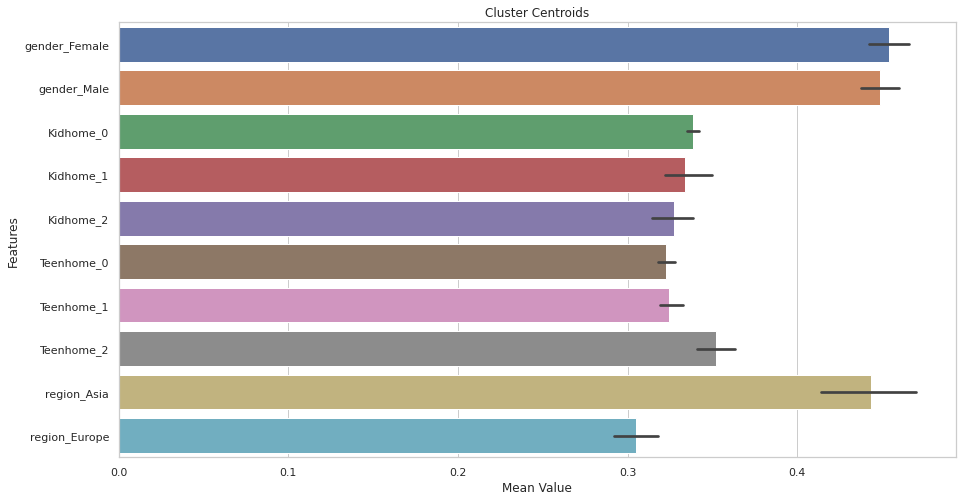

In [20]:
# Drop the 'CustomerID' column for visualization
centroid_df_plot = centroid_df.drop(columns=['CustomerID'])

# Set the style
sns.set(style="whitegrid")

# Plot the centroids using a bar plot
plt.figure(figsize=(15, 8))
sns.barplot(data=centroid_df_plot, orient='h')
plt.title('Cluster Centroids')
plt.xlabel('Mean Value')
plt.ylabel('Features')
plt.show()

### Visualization of Cluster Centroids: Heatmap

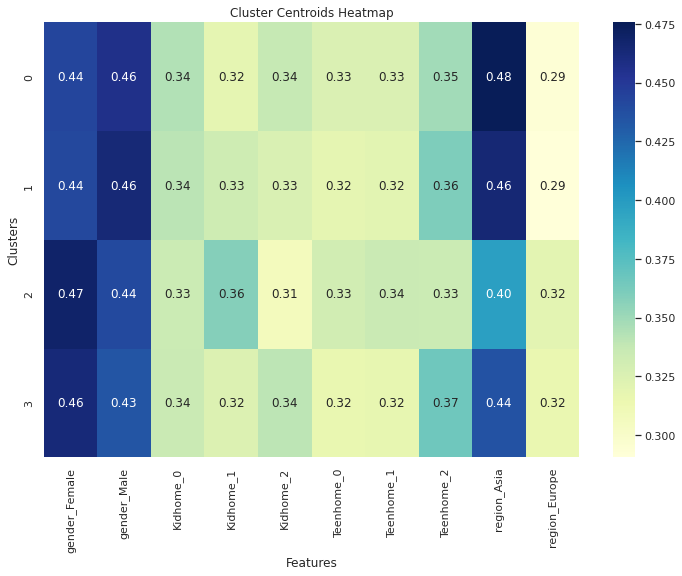

In [21]:
# Drop the 'CustomerID' column for visualization
centroid_df_heatmap = centroid_df.drop(columns=['CustomerID'])

# Plot the centroids using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(centroid_df_heatmap, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Cluster Centroids Heatmap')
plt.xlabel('Features')
plt.ylabel('Clusters')
plt.show()